# Course Project - Group 15
 #### Team members:
 - Iskander Gaba
 - Guillaume Kessibi

## Download the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import urllib
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle
import tensorflow as tf

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file", fname, "in the current directory...")

    if fname not in files:
        print(fname, "not found! Downloading from GitHub...")
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print(fname, "download and saved locally..")
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

Looking for file compas-scores-two-years.csv in the current directory...
File found in current directory..


## Load Data and Clean it up

__Load the data__

In [3]:
df = pd.read_csv(COMPAS_INPUT_FILE)

# The keys of the dataframe
print(df.keys())

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


__Cleanup the data__

In [4]:
# The missing values
print("The columns with missing values:")

mis_val_keys = []
mis_val_df = df.isnull()
for k in mis_val_df.keys():
    missing = False
    for cell in mis_val_df[k]:
        missing = missing or cell
    if missing:
        mis_val_keys.append(k)
print(mis_val_keys)

The columns with missing values:
['days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_desc', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'in_custody', 'out_custody']


In [0]:
df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

df = df[ (df.days_b_screening_arrest <= 30) &
(df.days_b_screening_arrest >= -30) &
(df.is_recid != -1) & (df.c_charge_degree != 'O') & (df.score_text != 'N/A') ]

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

## Basic Analysis of Demographics

In [6]:
print("Races in the database: ", df.race.unique())
print("Sexes in the database: ", df.sex.unique())

print("\nNumber of people by age category:")
print(df.groupby(['age_cat']).count()['id'])

print("\nNumber of people by race:")
print(df.groupby(['race']).count()['id'])

print("\nNumber of people by COMPAS score:")
print(df.groupby(['decile_score']).count()['id'])

print("\nNumber of people by COMPAS risk category:")
print(df.groupby(['score_text']).count()['id'])

Races in the database:  ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']
Sexes in the database:  ['Male' 'Female']

Number of people by age category:
age_cat
25 - 45            3532
Greater than 45    1293
Less than 25       1347
Name: id, dtype: int64

Number of people by race:
race
African-American    3175
Asian                 31
Caucasian           2103
Hispanic             509
Native American       11
Other                343
Name: id, dtype: int64

Number of people by COMPAS score:
decile_score
1     1286
2      822
3      647
4      666
5      582
6      529
7      496
8      420
9      420
10     304
Name: id, dtype: int64

Number of people by COMPAS risk category:
score_text
High      1144
Low       3421
Medium    1607
Name: id, dtype: int64


## Basic Investigations of Gender and Race biases in COMPAS Scores

In [7]:
print("\nMean COMPAS score of people by race:")
print(df.groupby(['race']).mean().decile_score)

print("\nMean COMPAS score of people by gender:")
print(df.groupby(['sex']).mean().decile_score)

print("\nMean COMPAS score of people by race and gender:")
print(df.groupby(['race', 'sex']).mean().decile_score)

#hist = df.groupby(['race', 'sex']).score_text.hist(bins=df.shape[1])

print("\nNumber of recidivism cases:", df.groupby(['two_year_recid']).count().id[1])

print("\nNumber of recidivism cases by race and gender:")
print(df.groupby(['race', 'sex']).count().two_year_recid)

print("\nCOMPAS Score by recidvism cases for different races:")
print(df.groupby(['race', 'decile_score']).count().two_year_recid)
print("\nCOMPAS Score by recidvism cases for different genders:")
print(df.groupby(['sex', 'decile_score']).count().two_year_recid)

print(df.groupby(['race', 'sex']).count()['two_year_recid'])


Mean COMPAS score of people by race:
race
African-American    5.276850
Asian               2.838710
Caucasian           3.635283
Hispanic            3.383104
Native American     6.454545
Other               2.889213
Name: decile_score, dtype: float64

Mean COMPAS score of people by gender:
sex
Female    4.063830
Male      4.501901
Name: decile_score, dtype: float64

Mean COMPAS score of people by race and gender:
race              sex   
African-American  Female    4.639344
                  Male      5.410129
Asian             Female    2.000000
                  Male      2.896552
Caucasian         Female    3.792531
                  Male      3.588526
Hispanic          Female    2.682927
                  Male      3.517564
Native American   Female    8.500000
                  Male      6.000000
Other             Female    2.741379
                  Male      2.919298
Name: decile_score, dtype: float64

Number of recidivism cases: 2809

Number of recidivism cases by race and gend

v_decile_score
1     145
2     172
3     220
4     206
5     206
6     197
7     178
8     142
9     138
10     57
Name: id, dtype: int64


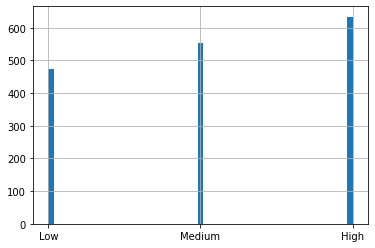

In [8]:
df_recid = df[df.two_year_recid == 1]
df_black = df_recid[df_recid.race == 'African-American']
df_white = df_recid[df_recid.race == 'Caucasian']

df_no_recid = df[df.two_year_recid == 0]
df_black_no = df_no_recid[df_no_recid.race == 'African-American']
df_white_no = df_no_recid[df_no_recid.race == 'Caucasian']

df_black.reset_index(inplace=True, drop=True)
df_white.reset_index(inplace=True, drop=True)

print(df_black.groupby(['v_decile_score']).count().id)
hist1 = df_black.groupby(['two_year_recid']).score_text.hist(bins=df_black.shape[1])

decile_score
1     128
2     100
3      82
4      98
5      91
6      93
7      68
8      72
9      55
10     35
Name: id, dtype: int64


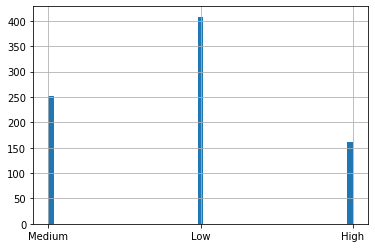

In [9]:
#print(df_white.groupby(['v_decile_score']).count().id)
print(df_white.groupby(['decile_score']).count().id)

#hist2 = df_white.groupby(['two_year_recid']).v_decile_score.hist(bins=df_white.shape[1])
#hist2 = df_white.groupby(['two_year_recid']).v_score_text.hist(bins=df_white.shape[1])

#hist2 = df_white.groupby(['two_year_recid']).decile_score.hist(bins=df_white.shape[1])
hist2 = df_white.groupby(['two_year_recid']).score_text.hist(bins=df_white.shape[1])

The majority of African-American people who recidivated were given high COMPAS scores, which is to be expected. Whereas the majority of Caucasians who recidivated were given low COMPAS scores, which is the exact opposite of what the COMPAS classifier should be doing. We can argue that there is a clear bias that favors Caucasians (If you are a Caucasian who is going to recidivate, you are more likely to be given a low COMPAS recidivation risk score).

By comparing the data people who did not recidivate, and plotting it, we find that the COMPAS calssifier is not biased against people who did not recidivate.

decile_score
1     230
2     233
3     200
4     246
5     229
6     254
7     255
8     270
9     265
10    214
Name: id, dtype: int64


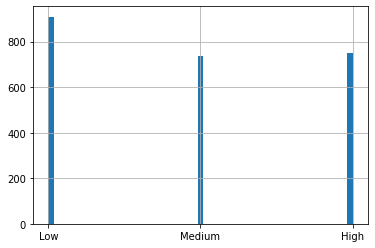

In [10]:
df_men = df_recid[df_recid.sex == 'Male']
df_women = df_recid[df_recid.sex == 'Female']
df_men_no = df_no_recid[df_no_recid.sex == 'Male']
df_women_no = df_no_recid[df_no_recid.sex == 'Female']
df_men.reset_index(inplace=True, drop=True)
df_women.reset_index(inplace=True, drop=True)

print(df_men.groupby(['decile_score']).count().id)

#hist1 = df_men.groupby(['two_year_recid']).decile_score.hist(bins=df_men.shape[1])
hist2 = df_men.groupby(['two_year_recid']).score_text.hist(bins=df_men.shape[1])

decile_score
1     47
2     31
3     44
4     45
5     51
6     54
7     43
8     32
9     35
10    31
Name: id, dtype: int64


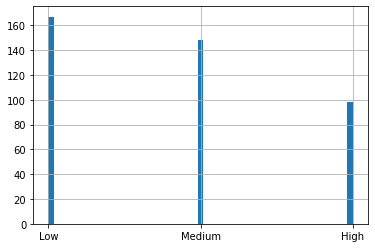

In [11]:
print(df_women.groupby(['decile_score']).count().id)

#hist1 = df_women.groupby(['two_year_recid']).decile_score.hist(bins=df_women.shape[1])
hist2 = df_women.groupby(['two_year_recid']).score_text.hist(bins=df_women.shape[1])

We tried to look for biases against sex alone, and while the differences are not big, women who recidivate are still having better chances of getting low to medium COMPAS scores compared to men.

## Fairness Investigation

### Independence

#### Race

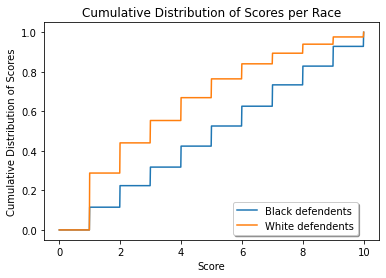

In [12]:
xbins = np.linspace(0, 10, 2**10)
x = (xbins[1:] + xbins[:-1])/2  # midpoint of each bin
dx = xbins[1:] - xbins[:-1]
yb, _ = np.histogram(df[df.race == 'African-American'].decile_score, density=True, bins=xbins)
yw, _ = np.histogram(df[df.race == 'Caucasian'].decile_score, density=True, bins=xbins)

# Cumulative distributions:
fb = yb.cumsum()*dx
fw = yw.cumsum()*dx

plt.plot(x, fb, label='Black defendents')
plt.plot(x, fw, label='White defendents')

plt.title('Cumulative Distribution of Scores per Race')
plt.xlabel('Score')
plt.ylabel('Cumulative Distribution of Scores')
plt.legend(loc='lower center', bbox_to_anchor=(0.75, 0.0), ncol=1, fancybox=True, shadow=True)

plt.show()

The plot above showcases that the COMPAS score relies on the race to scorea person. The probability for a certain defendant to be given a certain score is not equal for different races.

**Conclusion** Independence is not achieved on the race criteria.

#### Sex

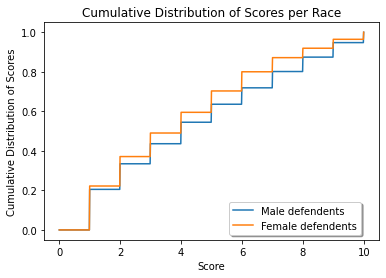

In [13]:
xbins = np.linspace(0, 10, 2**10)
x = (xbins[1:] + xbins[:-1])/2  # midpoint of each bin
dx = xbins[1:] - xbins[:-1]
yb, _ = np.histogram(df[df.sex == 'Male'].decile_score, density=True, bins=xbins)
yw, _ = np.histogram(df[df.sex == 'Female'].decile_score, density=True, bins=xbins)

# Cumulative distributions:
fb = yb.cumsum()*dx
fw = yw.cumsum()*dx

plt.plot(x, fb, label='Male defendents')
plt.plot(x, fw, label='Female defendents')

plt.title('Cumulative Distribution of Scores per Race')
plt.xlabel('Score')
plt.ylabel('Cumulative Distribution of Scores')
plt.legend(loc='lower center', bbox_to_anchor=(0.75, 0.0), ncol=1, fancybox=True, shadow=True)

plt.show()

It is clear from the plot above that the COMPAS score depends, more or less, on the sex of the defendants. The probability for a defendant to be given a certain score is not equal for different sexes. This difference is however small and could be acceptable with respect to the noise of the dataset.

**Conclusion** Even though independence is not 100% achieved among different sexes, it is close enough for us to accept it.

### Separation

#### Race

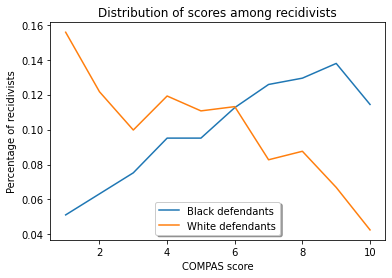

In [14]:
df_black_sep = df_black.groupby(['decile_score']).two_year_recid.count() / df_black.shape[0]
df_white_sep = df_white.groupby(['decile_score']).two_year_recid.count() / df_white.shape[0]
df_black_sep = df_black_sep.reset_index()
df_white_sep = df_white_sep.reset_index()

plt.plot(df_black_sep.decile_score, df_black_sep.two_year_recid, label='Black defendants')
plt.plot(df_white_sep.decile_score, df_white_sep.two_year_recid, label='White defendants')
plt.title('Distribution of scores among recidivists')
plt.xlabel('COMPAS score')
plt.ylabel('Percentage of recidivists')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=1, fancybox=True, shadow=True)
plt.show()

This plot shows the discrepency between the the distributions of scores among black and white recidivating individuals. For black people, the higher the score, the more defendants do indeed recidivate (which is the expected behavior) whereas for the white defendants, it's quite the opposite of the desired behavior of the COMPAS calssifier: The lower the COMPAS score, the more likely white defendants will recidivate.

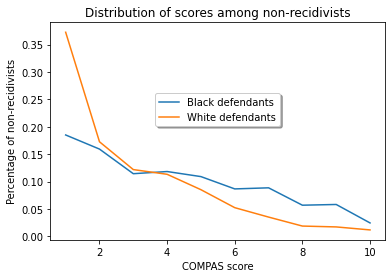

In [15]:
df_black_sep_no = df_black_no.groupby(['decile_score']).two_year_recid.count() / df_black_no.shape[0]
df_white_sep_no = df_white_no.groupby(['decile_score']).two_year_recid.count() / df_white_no.shape[0]
df_black_sep_no = df_black_sep_no.reset_index()
df_white_sep_no = df_white_sep_no.reset_index()

plt.plot(df_black_sep_no.decile_score, df_black_sep_no.two_year_recid, label='Black defendants')
plt.plot(df_white_sep_no.decile_score, df_white_sep_no.two_year_recid, label='White defendants')
plt.title('Distribution of scores among non-recidivists')
plt.xlabel('COMPAS score')
plt.ylabel('Percentage of non-recidivists')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.5), ncol=1, fancybox=True, shadow=True)
plt.show()

Once again, this plot shows that the white non-recidivating defendants are more likely to be classified as non-recidivists (COMPAS score < 4) and less likely to be classified as recidivists (COMPAS score >= 4) in comparison to their balck non-recidvist counterparts.

**Conclusion:** Separation is not achieved by the COMPAS classifier among different races.

In [16]:
# Threshold for all defendants = 4
print('\nSame threshold for both sensitive races')
print('\tFPR:')
print('\tBlack defendants:', df_black_no[df_black_no.decile_score >= 4].shape[0] / df_black_no.shape[0])
print('\tWhite defendants:', df_white_no[df_white_no.decile_score >= 4].shape[0] / df_white_no.shape[0])
print('\tFNR:')
print('\tBlack defendants:', df_black[df_black.decile_score < 4].shape[0] / df_black.shape[0])
print('\tWhite defendants:', df_white[df_white.decile_score < 4].shape[0] / df_white.shape[0])
print('\tPPV:')
print('\tBlack defendants:', df_black[df_black.decile_score >= 4].shape[0] / df[(df.race == 'African-American') & (df.decile_score >= 4)].shape[0])
print('\tWhite defendants:', df_white[df_white.decile_score >= 4].shape[0] / df[(df.race == 'Caucasian') & (df.decile_score >= 4)].shape[0])

# Threshold for black defendants = 6
# Threshold for white defendants = 4
print('\nDifferent threshold for each race')
print('\tFPR:')
print('\tBlack defendants:', df_black_no[df_black_no.decile_score >= 6].shape[0] / df_black_no.shape[0])
print('\tWhite defendants:', df_white_no[df_white_no.decile_score >= 4].shape[0] / df_white_no.shape[0])
print('\tFNR:')
print('\tBlack defendants:', df_black[df_black.decile_score < 6].shape[0] / df_black.shape[0])
print('\tWhite defendants:', df_white[df_white.decile_score < 4].shape[0] / df_white.shape[0])
print('\tPPV:')
print('\tBlack defendants:', df_black[df_black.decile_score >= 6].shape[0] / df[(df.race == 'African-American') & (df.decile_score >= 6)].shape[0])
print('\tWhite defendants:', df_white[df_white.decile_score >= 4].shape[0] / df[(df.race == 'Caucasian') & (df.decile_score >= 4)].shape[0])




Same threshold for both sensitive races
	FPR:
	Black defendants: 0.5416116248348745
	White defendants: 0.3333333333333333
	FNR:
	Black defendants: 0.1896447922937989
	White defendants: 0.3771289537712895
	PPV:
	Black defendants: 0.6214219759926131
	White defendants: 0.5452609158679447

Different threshold for each race
	FPR:
	Black defendants: 0.3143989431968296
	White defendants: 0.3333333333333333
	FNR:
	Black defendants: 0.3798916315472607
	White defendants: 0.3771289537712895
	PPV:
	Black defendants: 0.6839309428950863
	White defendants: 0.5452609158679447


**Conclusion:** One way to achieve separation is to change the thresholds so that False Positive Rates and False Negative Rates are close to each other across different groups of the sensitive attribute. In this case, setting the classification threshold for black defendants to `6` instead of `4` fixes that. This means that for black defendants, we need a stronger evidence to classify him/her as a high recidivation risk.

#### Sex

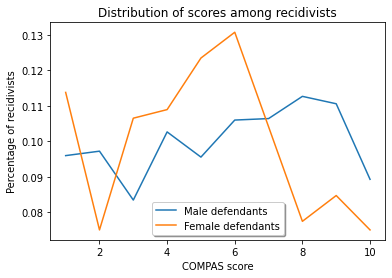

In [17]:
df_men_sep = df_men.groupby(['decile_score']).two_year_recid.count() / df_men.shape[0]
df_women_sep = df_women.groupby(['decile_score']).two_year_recid.count() / df_women.shape[0]

df_men_sep = df_men_sep.reset_index()
df_women_sep = df_women_sep.reset_index()

plt.plot(df_men_sep.decile_score, df_men_sep.two_year_recid, label='Male defendants')
plt.plot(df_women_sep.decile_score, df_women_sep.two_year_recid, label='Female defendants')
plt.title('Distribution of scores among recidivists')
plt.xlabel('COMPAS score')
plt.ylabel('Percentage of recidivists')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=1, fancybox=True, shadow=True)
plt.show()

This plot shows the discrepency between the the distributions of scores among male and female recidivists. For male defendants, the number of recidivists is roughly around 1/10 in each score level. For female defendants, however, most of the recidivists receive COMPAS scores of 6 or below, living the highest scores with the smallest amount of recidivists.

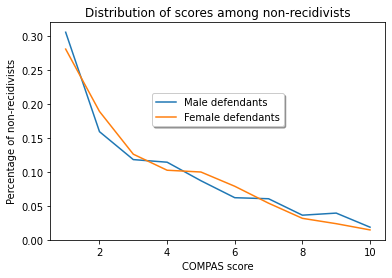

In [18]:
df_no_recid = df[df.two_year_recid == 0]
df_men_no = df_no_recid[df_no_recid.sex == 'Male']
df_women_no = df_no_recid[df_no_recid.sex == 'Female']

df_men_sep_no = df_men_no.groupby(['decile_score']).two_year_recid.count() / df_men_no.shape[0]
df_women_sep_no = df_women_no.groupby(['decile_score']).two_year_recid.count() / df_women_no.shape[0]
df_men_sep_no = df_men_sep_no.reset_index()
df_women_sep_no = df_women_sep_no.reset_index()

plt.plot(df_men_sep_no.decile_score, df_men_sep_no.two_year_recid, label='Male defendants')
plt.plot(df_women_sep_no.decile_score, df_women_sep_no.two_year_recid, label='Female defendants')
plt.title('Distribution of scores among non-recidivists')
plt.xlabel('COMPAS score')
plt.ylabel('Percentage of non-recidivists')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.5), ncol=1, fancybox=True, shadow=True)
plt.show()

For the non-recidivists, it appears that the distribution of scores among male and female defendants is roughly the same. The lower the score, the more unlikely a defendant to recidivate, which is to be expected.

**Conclusion:** Even though the separation appears to be achieved among the non-recidivists, it is clearly not the case among the recidivists. Female defendants appear to have a some advantage over male ones.

### Sufficiency

#### Race

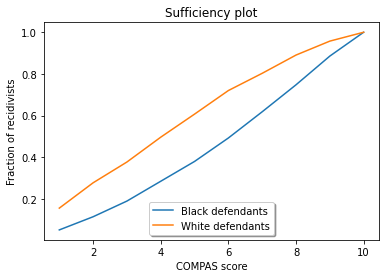

In [19]:
import matplotlib.pyplot as plt

df_black_calib = df_black.groupby(['decile_score']).two_year_recid.count().reset_index()
df_black_calib['cum_sum'] = df_black_calib['two_year_recid'].cumsum() / df_black.shape[0]
df_white_calib = df_white.groupby(['decile_score']).two_year_recid.count().reset_index()
df_white_calib['cum_sum'] = df_white_calib['two_year_recid'].cumsum() / df_white.shape[0]

plt.plot(df_black_calib.decile_score, df_black_calib.cum_sum, label='Black defendants')
plt.plot(df_white_calib.decile_score, df_white_calib.cum_sum, label='White defendants')
plt.title('Sufficiency plot')
plt.xlabel('COMPAS score')
plt.ylabel('Fraction of recidivists')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=1, fancybox=True, shadow=True)
plt.show()

The plot shows clearly that the white defendants have an advantage over the black defendants with respect to the sufficiency metric.

The probability of actually recidivating is not equal for black and white defendants who were given the same COMPAS score.

**Conclusion:** Sufficiency is not achieved within different races.

#### Sex

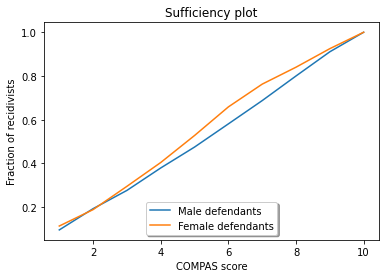

In [20]:
df_men_calib = df_men.groupby(['decile_score']).two_year_recid.count().reset_index()
df_men_calib['cum_sum'] = df_men_calib['two_year_recid'].cumsum() / df_men.shape[0]
df_women_calib = df_women.groupby(['decile_score']).two_year_recid.count().reset_index()
df_women_calib['cum_sum'] = df_women_calib['two_year_recid'].cumsum() / df_women.shape[0]

plt.plot(df_men_calib.decile_score, df_men_calib.cum_sum, label='Male defendants')
plt.plot(df_women_calib.decile_score, df_women_calib.cum_sum, label='Female defendants')
plt.title('Sufficiency plot')
plt.xlabel('COMPAS score')
plt.ylabel('Fraction of recidivists')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=1, fancybox=True, shadow=True)
plt.show()

The plot shows a slight discrepancy that gives female defendants an advantage over the male defendants with respect to the sufficiency metric.

The probability of actually recidivating is not equal for male and female defendants who were given the same COMPAS score. However, the differnce is not so sever like in the races case.

**Conclusion:** Even though it appears the female defendants have a slight sufficiency advantage over the male defendants, it is neverthelss not so significant and one could accept that sufficiency is achieved with some error margin.

### Conclusion
The COMPAS classifier is biased with respect to both sex and gender attributes with respect to independence, separation, and sufficiency. While the bias toward female defendants may be marginal and could be accepted, the bias toward Caucasian defendants is too big and has to be mitigated.

## Training a Classifier

**Note:** Since it was shown that the biggest bias is among racial groups, we shall focus on mitigating the bias just among racial groups in what follows. The same techniques are applicable to other sensitive attributes, namely the gender. We will attempt to build a universally fair classifier at the end.

In this section, we clean the data and keep only the relevant attributes to our classification. Then, we try different types of classifiers to see which one is most fit for our problem

### Cleaning the data

In the cleaning process, we decided to get rid of metadata that either represent redundant information (like start and end dates of jail time and number of days in jail etc.) or irrelevant information to the problem (like names and dates of birth, etc.) that will just crowd the data for no reason. We want to focus on features that affect defendants behavior and could indicate tendency to recidivate (like juvenile felony count and priors count) as well as those that may put some bias into the data (like race and sex) so that we can investigate it further and see what we can do about it.

The attributes that we decided to keep are: `age`, `sex`, `race`, `age_cat`, `priors_count`, `juv_fel_count`, `juv_misd_count`,  `juv_other_count`, `c_charge_degree`, and `two_year_recid`.


We then use a `LabelEncoder` to encode string features into numbers. For example, the sex attribute values will change from `Female` and `Male` to `0` and `1` so that we can fit in our classifier.

Finally, we split the data into training and testing sets and keep track of the whites and blacks in them.

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

dataset = df.filter(['age', 'sex', 'race', 'age_cat', 'priors_count', 'juv_fel_count', 'juv_misd_count',  'juv_other_count', 'c_charge_degree', 'two_year_recid'])

le = LabelEncoder()
dataset.sex = le.fit_transform(dataset.sex)
print("Sexes in order of encoding:", le.classes_)
dataset.age_cat = le.fit_transform(dataset.age_cat)
dataset.race = le.fit_transform(dataset.race)
print("Races in order of encoding:", le.classes_)
dataset.c_charge_degree = le.fit_transform(dataset.c_charge_degree)


X = dataset.drop(['two_year_recid'], axis=1)
y = dataset.filter(['two_year_recid'])
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.3, random_state=1234)

data_train = X_train
X_train.insert(9, 'two_year_recid', y_train, False)
X_train_black = X_train[X_train.race == 0]
X_train_white = X_train[X_train.race == 2]
y_train_black = X_train_black.filter(['two_year_recid'])
X_train_black = X_train_black.drop(['two_year_recid'], axis=1)
y_train_white = X_train_white.filter(['two_year_recid'])
X_train_white = X_train_white.drop(['two_year_recid'], axis=1)
X_train = X_train.drop(['two_year_recid'], axis=1)


data_test = X_test
X_test.insert(9, 'two_year_recid', y_test, False)
X_test_black = X_test[X_test.race == 0]
X_test_white = X_test[X_test.race == 2]
y_test_black = X_test_black.filter(['two_year_recid'])
X_test_black = X_test_black.drop(['two_year_recid'], axis=1)
y_test_white = X_test_white.filter(['two_year_recid'])
X_test_white = X_test_white.drop(['two_year_recid'], axis=1)
X_test = X_test.drop(['two_year_recid'], axis=1)

dataset

Sexes in order of encoding: ['Female' 'Male']
Races in order of encoding: ['African-American' 'Asian' 'Caucasian' 'Hispanic' 'Native American'
 'Other']


,age,sex,race,age_cat,priors_count,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,two_year_recid
0,69,1,5,1,0,0,0,0,0,0
1,34,1,0,0,0,0,0,0,0,1
2,24,1,0,2,4,0,0,1,0,1
3,44,1,5,0,0,0,0,0,1,0
4,41,1,2,0,14,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
6167,23,1,0,2,0,0,0,0,0,0
6168,23,1,0,2,0,0,0,0,0,0
6169,57,1,5,1,0,0,0,0,0,0
6170,33,0,0,0,3,0,0,0,1,0


### Deciding on the suitable type of classifiers for the problem

#### Logestic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
from sklearn.metrics import accuracy_score

y_pred = log_reg.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.6787257019438445


**Conclusion:** `LogisticRegression` calssifier is cheap in training and gives comparable accuracy results to what it was proposed by COMPAS accuracy.

#### Decision Trees

In [24]:
from sklearn import tree

dec_tree = tree.DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)

y_pred_tree = dec_tree.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_tree))

Accuracy: 0.6274298056155507


**Conclusion:** `DecisionTreeClassfier` is slightly down on the accuracy compared to the `LogisticRegression` calssifier for this problem and thus is eliminated.

#### Neural Network

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(12, input_dim=9, activation='relu'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='relu'))
# compile the keras model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=10)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3456 samples, validate on 864 samples
Epoch 1/100
3456/3456 [==============================] - 1s 171us/sample - loss: 0.4601 - acc: 0.5399 - val_loss: 0.4595 - val_acc: 0.5405
Epoch 2/100
3456/3456 [==============================] - 0s 143us/sample - loss: 0.4601 - acc: 0.5399 - val_loss: 0.4595 - val_acc: 0.5405
Epoch 3/100
3456/3456 [==============================] - 1s 148us/sample - loss: 0.4601 - acc: 0.5399 - val_loss: 0.4595 - val_acc: 0.5405
Epoch 4/100
3456/3456 [==============================] - 0s 141us/sample - loss: 0.4601 - acc: 0.5399 - val_loss: 0.4595 - val_acc: 0.5405
Epoch 5/100
3456/3456 [==============================] - 0s 141us/sample - loss: 0.4601 - acc: 0.5399 - val_loss: 0.4595 - val_acc: 0.5405
Epoch 6/100
3456/3456 [==============================] - 0s 142us/sample - loss: 0.4601 - acc: 0.5399 - val_loss: 0.4595 - val_acc: 0.5405
Epoch 7/100
3456/3456 [===============

In [26]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

1852/1852 [==============================] - 0s 21us/sample - loss: 0.4438 - acc: 0.5562
Accuracy: 0.5561555


**Conclusion:** A neural network gives comparable accuracy to the what it is given in the literature and to what the `LogisticRegression` produces. It is however more expensive to train.

#### Conclusion

We conclude that `LogisticRegression` is a good classifier for the data that we have and performs very well on both the training cost and classification performance levels.

### The Impact of Removing Sensitive Attributes

In this subsection, we investigate the impact of removing sensitive attributes from the dataset. We observe the impact on accuracy as well as model independence as it is often expected that removing sensitive attributes from the data will result into a "blind" justice and independent classification results from those sensitive attributes.

In [0]:
X_train_n = X_train.drop(['race', 'sex'], axis=1)
X_test_n = X_test.drop(['race', 'sex'], axis=1)
X_train_black_n = X_train_black.drop(['race', 'sex'], axis=1)
X_train_white_n = X_train_white.drop(['race', 'sex'], axis=1)
X_test_black_n = X_test_black.drop(['race', 'sex'], axis=1)
X_test_white_n = X_test_white.drop(['race', 'sex'], axis=1)

In [28]:
log_reg_neutral = LogisticRegression()
log_reg_neutral.fit(X_train_n, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy for the original model: 0.6787257019438445


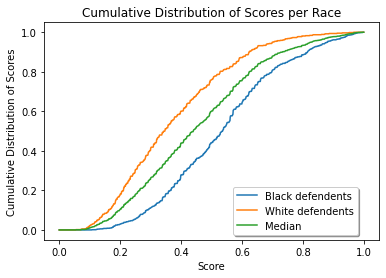

In [29]:
y_pred_n = log_reg_neutral.predict(X_test_n)
print('Accuracy for the original model:', accuracy_score(y_test, y_pred))
y_pred_black = log_reg.predict_proba(X_test_black)[:, 1]
y_pred_white = log_reg.predict_proba(X_test_white)[:, 1]
y_pred_black_n = log_reg_neutral.predict_proba(X_test_black_n)[:, 1]
y_pred_white_n = log_reg_neutral.predict_proba(X_test_white_n)[:, 1]

xbins = np.linspace(0, 1, 2**10)
x = (xbins[1:] + xbins[:-1])/2  # midpoint of each bin
dx = xbins[1:] - xbins[:-1]
yb, _ = np.histogram(y_pred_black, density=True, bins=xbins)
yw, _ = np.histogram(y_pred_white, density=True, bins=xbins)

# Cumulative distributions:
fb = yb.cumsum()*dx
fw = yw.cumsum()*dx

# Median
f_med = (fb + fw) / 2
plt.plot(x, fb, label='Black defendents')
plt.plot(x, fw, label='White defendents')
plt.plot(x, f_med, label='Median')

plt.title('Cumulative Distribution of Scores per Race')
plt.xlabel('Score')
plt.ylabel('Cumulative Distribution of Scores')
plt.legend(loc='lower center', bbox_to_anchor=(0.75, 0.0), ncol=1, fancybox=True, shadow=True)

plt.show()

Accuracy for the "neutral" model: 0.677645788336933


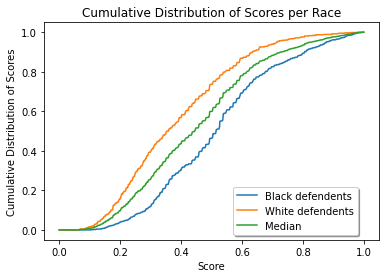

In [30]:
print('Accuracy for the "neutral" model:', accuracy_score(y_test, y_pred_n))

xbins = np.linspace(0, 1, 2**10)
x = (xbins[1:] + xbins[:-1])/2  # midpoint of each bin
dx = xbins[1:] - xbins[:-1]
yb, _ = np.histogram(y_pred_black_n, density=True, bins=xbins)
yw, _ = np.histogram(y_pred_white_n, density=True, bins=xbins)

# Cumulative distributions:
fb = yb.cumsum()*dx
fw = yw.cumsum()*dx

# Median
f_med = (fb + fw) / 2
plt.plot(x, fb, label='Black defendents')
plt.plot(x, fw, label='White defendents')
plt.plot(x, f_med, label='Median')

plt.title('Cumulative Distribution of Scores per Race')
plt.xlabel('Score')
plt.ylabel('Cumulative Distribution of Scores')
plt.legend(loc='lower center', bbox_to_anchor=(0.75, 0.0), ncol=1, fancybox=True, shadow=True)

plt.show()

**Conclusion:** Removing the sensitive attributes from the dataset did not result in an accuracy decrease. However, it also did very little to help with independence. It is therefore and as expected a bad technique to achieve independence.

### Tackling Fairness in our Classifier

#### Independence

In this section, we show one good method of achieving independence based on the [paper](https://arxiv.org/abs/1412.3756) by Feldman et. al. and display how we can repair the score partially (or completely to achieve perfect independence over accuracy) inspired by this [tutorial](https://faculty.ai/blog/how-to-repair-an-unfair-classifier-part-1).

Original accuracy: 0.6787257019438445


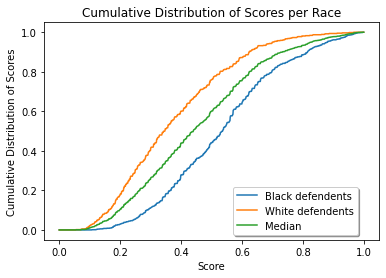

In [31]:
print('Original accuracy:', accuracy_score(y_test, y_pred))

xbins = np.linspace(0, 1, 2**10)
x = (xbins[1:] + xbins[:-1])/2  # midpoint of each bin
dx = xbins[1:] - xbins[:-1]
yb, _ = np.histogram(y_pred_black, density=True, bins=xbins)
yw, _ = np.histogram(y_pred_white, density=True, bins=xbins)

# Cumulative distributions:
fb = yb.cumsum()*dx
fw = yw.cumsum()*dx

# Median
f_med = (fb + fw) / 2

plt.plot(x, fb, label='Black defendents')
plt.plot(x, fw, label='White defendents')
plt.plot(x, f_med, label='Median')

plt.title('Cumulative Distribution of Scores per Race')
plt.xlabel('Score')
plt.ylabel('Cumulative Distribution of Scores')
plt.legend(loc='lower center', bbox_to_anchor=(0.75, 0.0), ncol=1, fancybox=True, shadow=True)

plt.show()

In an ideal world where the independence criterion is fully met, both distributions from the plot above should be identical to the median. Below, we remove disparate impact and try to get both distributions closer to the median distribution.

##### Repairing the scores

In [0]:
# Repair the score up until a degree gamma
def repair_score(groups, y_pred_arg, gamma=0.5):
  y_repair = np.zeros(y_pred_arg.size)
  
  for i in range(y_pred_arg.size):
    score = y_pred_arg[i]
    race = groups[i]

    x_arg = np.abs(x - score).argmin()

    if race == 0:    
        f_val = fb[x_arg]
    elif race == 2:
        f_val = fw[x_arg]
    else:
        y_repair[i] = y_pred_arg[i]
        continue
    f_arg = np.abs(f_space - f_val).argmin()
    y_repair[i] = y_pred_arg[i] + gamma * (x_med[f_arg] - y_pred_arg[i])

  return y_repair

Repaired accuracy: 0.6695464362850972


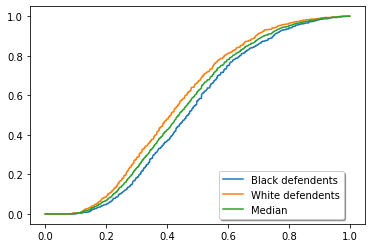

In [33]:
# Compute the median distribution
f_space = np.linspace(0,1, 2**9) 
x_med = np.zeros_like(f_space)
for i, f in enumerate(f_space):
    b_arg = np.abs(fb - f).argmin()
    w_arg = np.abs(fw - f).argmin()
    x_med[i] = np.median([x[b_arg], x[w_arg]])

y_pred_proba = log_reg.predict_proba(X_test)[:,1]
y_pred_r = repair_score(np.array(X_test.race), y_pred_proba, gamma=0.7)

for i in range(y_pred_r.size):
  if y_pred_r[i] < 0.5:
    y_pred_r[i] = 0
  else:
    y_pred_r[i] = 1

print('Repaired accuracy:', accuracy_score(y_test, y_pred_r))

xbins = np.linspace(0, 1, 2**10)
x = (xbins[1:] + xbins[:-1])/2  # midpoint of each bin
dx = xbins[1:] - xbins[:-1]
y_pred_black_rep = repair_score(np.array(X_test_black.race), y_pred_black, gamma=0.7)
y_pred_white_rep = repair_score(np.array(X_test_white.race), y_pred_white, gamma=0.7)
ybr, _ = np.histogram(y_pred_black_rep, density=True, bins=xbins)
ywr, _ = np.histogram(y_pred_white_rep, density=True, bins=xbins)

# Cumulative distributions:
fbr = ybr.cumsum()*dx
fwr = ywr.cumsum()*dx
fmr = (fbr + fwr) / 2

plt.plot(x, fbr, label='Black defendents')
plt.plot(x, fwr, label='White defendents')
plt.plot(x, fmr, label='Median')

plt.legend(loc='lower center', bbox_to_anchor=(0.75, 0.0), ncol=1, fancybox=True, shadow=True)
plt.show()

**Conclusion:** By sacrificing about 2% of our model's accuracy, we have achieved independence. The idea behind the algorithm is to find the median distribution and promote scores from distributions of both sensitive groups closer to it up to a certain degree thus achieving a statistically independent model.

#### Separation

Independence may not be interesting in certain contexts. In fact, it is not in most contexts. What if the value of a sensitive group has to do with the classification result? In that case, we resort to separation criterion. In this subsection, we show one good method of achieving separation based on the [paper](https://arxiv.org/abs/1610.02413) by Hardt et. al. The code in this section is heavily inspired by this [tutorial](https://faculty.ai/blog/how-to-repair-an-unfair-classifier-part-2).

The idea here is to force the classifier to have certain true positive and true negative rates that suite the problem very well.

In [0]:
def check_lengths(*arrays):
    """
    Check that all arrays have the same length.
    Parameters
    ----------
    *arrays : list or tuple of input objects.
        Objects that will be checked.
    """
    lengths = [len(X) for X in arrays if X is not None]
    uniques = np.unique(lengths)
    if len(uniques) > 1:
        message = "Input arrays should all be the same length."
        raise ValueError(message)


def check_binaries(*arrays):
    """
    Check that all values in the arrays are 0s or 1s.
    Parameters
    ----------
    *arrays : list or tuple of input objects.
        Objects that will be checked.
    """
    values = [set(X) for X in arrays if X is not None]
    all_valid = all(v.issubset({0, 1}) for v in values)
    if not all_valid:
        message = "Input arrays should only contain 0s and/or 1s."
        raise ValueError(message)


def tp_rate(y_true, y_pred) -> float:
    """
    True positive rate.
    Parameters
    ----------
    y_true : 1d array-like of binaries
        Ground truth (correct) target values.
    y_pred : 1d array-like of binaries
        Estimated targets as returned by a classifier.
    """
    check_lengths(y_true, y_pred)
    check_binaries(y_true, y_pred)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if all(y_true == 0):
        return np.nan

    rate = (y_true @ y_pred) / (y_true @ y_true)
    return rate


def fp_rate(y_true, y_pred) -> float:
    """
    False positive rate.
    Parameters
    ----------
    y_true : 1d array-like of binaries
        Ground truth (correct) target values.
    y_pred : 1d array-like of binaries
        Estimated targets as returned by a classifier.
    """
    check_lengths(y_true, y_pred)
    check_binaries(y_true, y_pred)
    y_false = 1 - np.array(y_true)
    y_pred = np.array(y_pred)
    if all(y_false == 0):
        return np.nan

    rate = (y_false @ (y_pred)) / (y_false @ y_false)
    return rate


def classification_report(y_true, y_pred, A) -> str:
    """
    String showing the true positive rate and false
    positive rate for each group.
    Parameters
    ----------
    y_true : 1d array-like of binaries
        Ground truth (correct) target values.
    y_pred : 1d array-like of binaries
        Estimated targets as returned by a classifier.
    A: 1d array like
        Labels for the different groups.
    """
    check_lengths(y_true, y_pred, A)
    check_binaries(y_true, y_pred)
    groups = np.unique(A)
    header = "{:<4}{:^6}{:^6}".format("A", "TPR", "FPR")
    row_fmt = "{:<4}{:^6.2f}{:^6.2f}"
    lines = [header, "-" * len(header)]
    for g in groups:
        y_true_g = y_true[A == g]
        y_pred_g = y_pred[A == g]
        tpr_g = tp_rate(y_true_g, y_pred_g)
        fpr_g = fp_rate(y_true_g, y_pred_g)
        lines.append(row_fmt.format(g, tpr_g, fpr_g))

    tpr = tp_rate(y_true, y_pred)
    fpr = fp_rate(y_true, y_pred)
    lines.append(row_fmt.format("All", tpr, fpr))
    report = "\n".join(lines)
    return report

In [0]:
from scipy.optimize import minimize
from sklearn.metrics import roc_curve

class SeparatedClassifier:
    def __init__(self, y_train, score_train, group_train):
        check_lengths(y_train, score_train, group_train)
        check_binaries(y_train)
        self.y_train = np.array(y_train)
        self.score_train = np.array(score_train)
        self.group_train = np.array(group_train)

    def fit(self, goal_fpr, goal_tpr):
        groups = np.unique(self.group_train)
        self.randomized_thresholds = dict()
        for g in groups:
            y_true_g = self.y_train[self.group_train == g]
            score_g = self.score_train[self.group_train == g]
            self.randomized_thresholds[g] = self._find_thresholds_and_probas(
                y_true_g, score_g, goal_fpr, goal_tpr
            )

    def fair_predict(self, score_test, group_test):
        groups = np.unique(group_test)
        y_pred = []
        for score, g in zip(score_test, group_test):
            *a, p = self.randomized_thresholds[g]
            t = np.random.choice(a, p=[1 - p, p])
            y_pred.append(1 if score >= t else 0)

        return np.array(y_pred)

    def _find_thresholds_and_probas(self, y_true, scores, goal_fpr, goal_tpr):
        fpr, tpr, thresholds = roc_curve(y_true, scores, drop_intermediate=False)

        def distance(d3array):
            t0, t1, p = d3array
            i = np.argmin(abs(t0 - thresholds))
            j = np.argmin(abs(t1 - thresholds))
            x = fpr[i] + p * (fpr[j] - fpr[i])
            y = tpr[i] + p * (tpr[j] - tpr[i])
            return np.hypot(x - goal_fpr, y - goal_tpr)

        initial_guess = np.array([0.3, 0.5, 0.5])
        res = minimize(
            distance, initial_guess, method="nelder-mead", options={"xtol": 1e-10}
        )
        t0, t1, p = res["x"]
        return t0, t1, p

A    TPR   FPR  
----------------
0    0.75  0.37 
1    0.40  0.00 
2    0.39  0.15 
3    0.33  0.17 
4    1.00  0.20 
5    0.14  0.04 
All  0.58  0.24 
Original accuracy: 0.6787257019438445


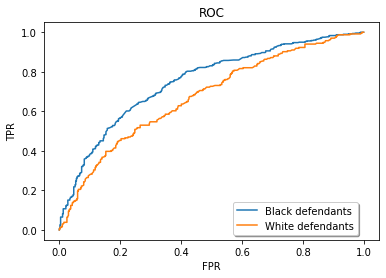

In [36]:
from sklearn import metrics

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    dataset.drop(columns='two_year_recid'),
    dataset['two_year_recid'],
    dataset['race'],
    test_size=0.3,
    random_state=SEED,
)

X_test.insert(0, 'two_year_recid', y_test)
X_test_black = X_test[X_test.race == 0]
X_test_white = X_test[X_test.race == 2]
y_test_black = X_test_black['two_year_recid']
y_test_white= X_test_white['two_year_recid']
X_test = X_test.drop('two_year_recid', axis=1)
X_test_black = X_test_black.drop('two_year_recid', axis=1)
X_test_white = X_test_white.drop('two_year_recid', axis=1)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred, group_test))

y_pred_black = log_reg.predict_proba(X_test_black)[:, 1]
y_pred_white = log_reg.predict_proba(X_test_white)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_black, y_pred_black)
plt.plot(fpr, tpr, label='Black defendants')
fpr, tpr, _ = metrics.roc_curve(y_test_white, y_pred_white)
plt.plot(fpr, tpr, label='White defendants')

print('Original accuracy:', accuracy_score(y_test, y_pred))

plt.title('ROC')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower center', bbox_to_anchor=(0.75, 0.0), ncol=1, fancybox=True, shadow=True)
plt.show()

As we can see from the ROC curve, the white defendants are judged more leniently. We choose our goal true positive rate to be `0.6` and our goal false positive rate to be `0.4`.

In [37]:
score_train = log_reg.predict_proba(X_train)[:, 1]
score_test = log_reg.predict_proba(X_test)[:, 1]
goal_tpr, goal_fpr = 0.6, 0.4

fair_clf = SeparatedClassifier(y_train, score_train, group_train)
fair_clf.fit(goal_fpr, goal_tpr)

for k, v in fair_clf.randomized_thresholds.items():
    print(f"Group {k}: t0={v[0]:.2f}, t1={v[1]:.2f}, p={v[2]:.2f}")

y_pred_fair = fair_clf.fair_predict(score_test, group_test)
print(classification_report(y_test, y_pred_fair, group_test))
print('Repaired accuracy:', accuracy_score(y_test, y_pred_fair))

Group 0: t0=0.35, t1=0.72, p=0.48
Group 1: t0=0.31, t1=0.61, p=0.22
Group 2: t0=0.24, t1=0.55, p=0.49
Group 3: t0=0.24, t1=0.56, p=0.48
Group 4: t0=0.22, t1=0.49, p=0.66
Group 5: t0=0.18, t1=0.50, p=0.55
A    TPR   FPR  
----------------
0    0.62  0.42 
1    0.80  0.60 
2    0.59  0.40 
3    0.55  0.50 
4    1.00  0.40 
5    0.59  0.44 
All  0.61  0.42 
Repaired accuracy: 0.5912526997840173


**Conclusion:** Although we lost some accuracy, we achieved a certain degree of separation by forcing both True and False Positive rates to be roughly equal to a certain value across all groups.

## AI Fairness in Practice: AIF360

As we have seen, reparing classification is a cumbersome work that requires a lot of hacky tricks as of now. We hoped that we find a mature library for this novel field and we stumbled upon IBM's [AIF360](https://github.com/IBM/AIF360).

Below, we use this library to optimize fairness using one Pre-processing approach, one in-processing approach, and one post-processing approach.

The code below is heavily inspired by the example notebooks published by IBM [here](https://github.com/IBM/AIF360/blob/master/examples).

### Prepare the Library

In [38]:
!pip install aif360

In [0]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import CompasDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas


from sklearn.preprocessing import StandardScaler, MaxAbsScaler

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

### Load and Clean the Data

In [40]:

dataset_orig = load_preproc_data_compas(['race'])
compas, d = dataset_orig.convert_to_dataframe()

unprivileged_races, privileged_races = [{'race': 0}], [{'race': 1}]
unprivileged_sex, privileged_sex = [{'sex': 0}], [{'sex': 1}]
unprivileged_groups, privileged_groups = [{'race': 0}, {'sex': 0}], [{'race': 1}, {'sex': 1}]

compas

,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
8,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
10,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
14,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10994,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
10995,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
10996,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
10997,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### Pre-processing

#### Optimized Pre-processing

This is one of the data pre-processing methods available in the library that allows the user to mitigate biases in the data before starting the learning process. This is based on the [paper](http://papers.nips.cc/paper/6988-optimized-pre-processing-for-discrimination-prevention) by Calmon and al.

In [0]:
all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

optim_options = {
        "distortion_fun": get_distortion_compas,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
}

In [0]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

In [43]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_races,
                                             privileged_groups=privileged_races)
print("Original training dataset:")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Original training dataset:
Difference in mean outcomes between unprivileged and privileged groups = -0.112661


In [44]:
OP = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_races,
                  privileged_groups = privileged_races)

OP = OP.fit(dataset_orig_train)

# Transform training data and align features
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)
dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

/usr/local/lib/python3.6/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "


Optimized Preprocessing: Objective converged to 0.000000


In [45]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_races,
                                         privileged_groups=privileged_races)
print("Transformed training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

Transformed training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.045080


In [46]:
dataset_orig_test = dataset_transf_train.align_datasets(dataset_orig_test)

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                         unprivileged_groups=unprivileged_races,
                                         privileged_groups=privileged_races)
print("Original test dataset")
print("Difference in mean outcomes between unprivileged and privileged races = %f" % metric_orig_test.mean_difference())

Original test dataset
Difference in mean outcomes between unprivileged and privileged races = -0.193562


In [47]:
dataset_transf_test = OP.transform(dataset_orig_test, transform_Y = True)
dataset_transf_test = dataset_orig_test.align_datasets(dataset_transf_test)

metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                         unprivileged_groups=unprivileged_races,
                                         privileged_groups=privileged_races)
print("Transformed test dataset")
print("Difference in mean outcomes between unprivileged and privileged races = %f" % metric_transf_test.mean_difference())

Transformed test dataset
Difference in mean outcomes between unprivileged and privileged races = -0.114978


**Conclusion:** Although this approach mitigates some of the bias in the dataset, this is not the most powerful technique of them all. It only optimizes the difference in mean outcome between privileged and unprivileged groups before the training.

### In-processing
#### Adversarial debiasing 

This is a fairly complex technique described by the [paper](https://arxiv.org/abs/1801.07593) from Zhang et al. where the optimization happens while training the classifier.

The idea here is to train two classifiers: One that computes the score, and another adversary classifier that tries to predict the the sensitive group all while minimizing the loss one loss function for each.

In [0]:
dataset_orig = load_preproc_data_compas()
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [49]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_races,
                                             privileged_groups=privileged_races)
print("Original training dataset")
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_races,
                                             privileged_groups=privileged_races)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

Original training dataset
Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.138989
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.116667


In [50]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_races,
                             privileged_groups=privileged_races)
print("Scaled dataset - Verify that the scaling does not affect the group label statistics")
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_races,
                             privileged_groups=privileged_races)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

Scaled dataset - Verify that the scaling does not affect the group label statistics
Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.138989
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.116667


**Learn without debiasing**

In [0]:
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_races,
                          unprivileged_groups = unprivileged_races,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

In [52]:
plain_model.fit(dataset_orig_train)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





epoch 0; iter: 0; batch classifier loss: 0.693906
epoch 1; iter: 0; batch classifier loss: 0.661016
epoch 2; iter: 0; batch classifier loss: 0.673051
epoch 3; iter: 0; batch classifier loss: 0.624207
epoch 4; iter: 0; batch classifier loss: 0.631822
epoch 5; iter: 0; batch classifier loss: 0.602759
epoch 6; iter: 0; batch classifier loss: 0.584767
epoch 7; iter: 0; batch classifier loss: 0.610823
epoch 8; iter: 0; b

In [0]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [54]:
# Metrics for the dataset from plain model (without debiasing)
print("Plain model - without debiasing - dataset metrics")
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_races,
                                             privileged_groups=privileged_races)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_races,
                                             privileged_groups=privileged_races)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

print("Plain model - without debiasing - classification metrics")
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_races,
                                                 privileged_groups=privileged_races)
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

Plain model - without debiasing - dataset metrics
Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.304663
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.269071
Plain model - without debiasing - classification metrics
Test set: Classification accuracy = 0.656566
Test set: Balanced classification accuracy = 0.651965
Test set: Disparate impact = 0.637365
Test set: Equal opportunity difference = -0.226496
Test set: Average odds difference = -0.238079
Test set: Theil_index = 0.213386


**Learning with debiasing**

In [0]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()

In [0]:
# Learn parameters with debias set to True
debiased_model = AdversarialDebiasing(privileged_groups = privileged_races,
                          unprivileged_groups = unprivileged_races,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)

In [57]:
debiased_model.fit(dataset_orig_train)

epoch 0; iter: 0; batch classifier loss: 0.700128; batch adversarial loss: 0.788289
epoch 1; iter: 0; batch classifier loss: 0.631376; batch adversarial loss: 0.807773
epoch 2; iter: 0; batch classifier loss: 0.613992; batch adversarial loss: 0.840894
epoch 3; iter: 0; batch classifier loss: 0.641198; batch adversarial loss: 0.807954
epoch 4; iter: 0; batch classifier loss: 0.646652; batch adversarial loss: 0.819806
epoch 5; iter: 0; batch classifier loss: 0.671288; batch adversarial loss: 0.857024
epoch 6; iter: 0; batch classifier loss: 0.717095; batch adversarial loss: 0.876232
epoch 7; iter: 0; batch classifier loss: 0.762086; batch adversarial loss: 0.824050
epoch 8; iter: 0; batch classifier loss: 0.740915; batch adversarial loss: 0.832519
epoch 9; iter: 0; batch classifier loss: 0.670616; batch adversarial loss: 0.829632
epoch 10; iter: 0; batch classifier loss: 0.762637; batch adversarial loss: 0.803002
epoch 11; iter: 0; batch classifier loss: 0.835775; batch adversarial loss:

In [0]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [59]:
# Metrics for the dataset from plain model (without debiasing)
print("Plain model - without debiasing - dataset metrics")
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
print("\nModel - with debiasing - dataset metrics")
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_races,
                                             privileged_groups=privileged_races)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_races,
                                             privileged_groups=privileged_races)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



print("\nPlain model - without debiasing - classification metrics")
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())



print("\nModel - with debiasing - classification metrics")
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_races,
                                                 privileged_groups=privileged_races)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

Plain model - without debiasing - dataset metrics
Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.304663
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.269071

Model - with debiasing - dataset metrics
Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.305108
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.274519

Plain model - without debiasing - classification metrics
Test set: Classification accuracy = 0.656566
Test set: Balanced classification accuracy = 0.651965
Test set: Disparate impact = 0.637365
Test set: Equal opportunity difference = -0.226496
Test set: Average odds difference = -0.238079
Test set: Theil_index = 0.213386

Model - with debiasing - classification metrics
Test set: Classification accuracy = 0.654040
Test set: Balanced classification accuracy = 0.649004
Test set: Disparate impact = 0.634755
Test set: Equal opportu

**Conclusion:** This model produces better metric results all overall with a better desparate impact (independence) and better equal opportunity difference (separation).

### Post-Processing

#### Reject Option Classification

This is a fairly complex technique described by the [paper](https://ieeexplore.ieee.org/document/6413831) from Kamiran et al. where the optimization happens after training the classifier, much like we did earlier.

The idea behind thsi classifier is to look at the classification score of each individual using a certain doubt threshold `d`. If the score of an individual is really close to 0 or 1, then their classification remains the same. However, if their score is close to the classification threshold `t` (+/- `d`) then we reject the classification and instead, we look at sensitive group this individual belongs to. If the group is unprvivilged, then we classify the individual a favorable classification. Otherwise, we classify them an unfavorable classification. Here, we choose `Equal opportunity difference` to be the metric that we want to optimize against as we want to optimize separation. 

In [0]:
# Metric used (should be one of allowed_metrics)
metric_name = "Equal opportunity difference"

# Upper and lower bound on the fairness metric used
metric_ub = 0.05
metric_lb = -0.05

In [61]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_races,
                                             privileged_groups=privileged_races)
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.138989


In [0]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred

In [0]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [64]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_races,
                                             privileged_groups=privileged_races)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)



Best balanced accuracy (no fairness constraints) = 0.6829
Optimal classification threshold (no fairness constraints) = 0.4555


In [0]:
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_races, 
                                 privileged_groups=privileged_races, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)
ROC = ROC.fit(dataset_orig_valid, dataset_orig_valid_pred)

In [66]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.5049
Optimal ROC margin = 0.0707


In [67]:
# Metrics for the validation set
fav_inds = dataset_orig_valid_pred.scores > best_class_thresh
dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label

print("Validation set")
print("Raw predictions - No fairness constraints, only maximizing balanced accuracy")

metric_valid_bef = compute_metrics(dataset_orig_valid, dataset_orig_valid_pred, 
                unprivileged_races, privileged_races)


Validation set
Raw predictions - No fairness constraints, only maximizing balanced accuracy
Balanced accuracy = 0.6829
Statistical parity difference = -0.2530
Disparate impact = 0.6645
Average odds difference = -0.2009
Equal opportunity difference = -0.1775
Theil index = 0.1762


In [68]:
# Transform the validation set
dataset_transf_valid_pred = ROC.predict(dataset_orig_valid_pred)
print("Validation set")
print("Transformed predictions - With fairness constraints")
metric_valid_aft = compute_metrics(dataset_orig_valid, dataset_transf_valid_pred, 
                unprivileged_races, privileged_races)

Validation set
Transformed predictions - With fairness constraints
Balanced accuracy = 0.6662
Statistical parity difference = -0.0673
Disparate impact = 0.8858
Average odds difference = -0.0185
Equal opportunity difference = 0.0267
Theil index = 0.2160


In [69]:
# Metrics for the test set
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

print("Test set")
print("Raw predictions - No fairness constraints, only maximizing balanced accuracy")

metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                unprivileged_races, privileged_races)

Test set
Raw predictions - No fairness constraints, only maximizing balanced accuracy
Balanced accuracy = 0.6598
Statistical parity difference = -0.2128
Disparate impact = 0.7132
Average odds difference = -0.1814
Equal opportunity difference = -0.1517
Theil index = 0.1886


In [70]:
# Metrics for the transformed test set
dataset_transf_test_pred = ROC.predict(dataset_orig_test_pred)

print("Test set")
print("Transformed predictions - With fairness constraints")
metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                unprivileged_races, privileged_races)

Test set
Transformed predictions - With fairness constraints
Balanced accuracy = 0.6548
Statistical parity difference = -0.0125
Disparate impact = 0.9778
Average odds difference = 0.0242
Equal opportunity difference = 0.0224
Theil index = 0.2255


**Conclusion:** The Reject Option appears to be a solid choice for the data we have. This method is capable of optimizing the `Equal opportunity difference` and therefore enforce separation while optimizing all other metrics significantly.

#### Conclusion
In this subsection, we explored 3 different fairness achievement techniques using AIF360 in three stages all of the machine learning pipeline: before training, while training, and after training.

We observed that for the problem at hand, Reject Option Classification seems to work well. It also corresponds to the idea of giving the unpriviliged a second chance when they their score is really close to the threshold and therefore we decided to use it to build our fair classifier.

## Fair Classifier

In this final section, we attempt to create a final universal classifier that is fair to defendants regardless of their sex or race.

To do that, we attempt to use two Reject Option Classifiers for each sensitive attribute and combine classification results of both at the end.

In [0]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

# Metric used (should be one of allowed_metrics)
metric_name = "Equal opportunity difference"

# Upper and lower bound on the fairness metric used
metric_ub = 0.05
metric_lb = -0.05

In [72]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_races,
                                             privileged_groups=privileged_races)
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups (race) = %f" % metric_orig_train.mean_difference())

metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_sex,
                                             privileged_groups=privileged_sex)
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups (sex) = %f" % metric_orig_train.mean_difference())

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups (race) = -0.128830
Original training dataset
Difference in mean outcomes between unprivileged and privileged groups (sex) = -0.143673


In [0]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred

In [0]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [75]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_races,
                                             privileged_groups=privileged_races)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.6610
Optimal classification threshold (no fairness constraints) = 0.4654


In [0]:
ROC_sex = RejectOptionClassification(unprivileged_groups=unprivileged_sex, 
                                 privileged_groups=privileged_sex, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)

ROC_race = RejectOptionClassification(unprivileged_groups=unprivileged_races, 
                                 privileged_groups=privileged_races, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)


ROC_sex = ROC_sex.fit(dataset_orig_valid, dataset_orig_valid_pred)
ROC_race = ROC_race.fit(dataset_orig_valid, dataset_orig_valid_pred)

In [77]:
print("Optimal classification threshold (with fairness constraints, race) = %.4f" % ROC_race.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC_race.ROC_margin)
print("Optimal classification threshold (with fairness constraints, sex) = %.4f" % ROC_sex.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC_sex.ROC_margin)

Optimal classification threshold (with fairness constraints, race) = 0.5049
Optimal ROC margin = 0.0707
Optimal classification threshold (with fairness constraints, sex) = 0.4951
Optimal ROC margin = 0.0303


In [78]:
# Metrics for the validation set
fav_inds = dataset_orig_valid_pred.scores > best_class_thresh
dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label

print("Validation set")
print("Raw predictions - No fairness constraints, only maximizing balanced accuracy (race)")
metric_valid_bef = compute_metrics(dataset_orig_valid, dataset_orig_valid_pred, 
                unprivileged_races, privileged_races)

print("\nRaw predictions - No fairness constraints, only maximizing balanced accuracy (sex)")
metric_valid_bef = compute_metrics(dataset_orig_valid, dataset_orig_valid_pred, 
                unprivileged_sex, privileged_sex)


Validation set
Raw predictions - No fairness constraints, only maximizing balanced accuracy (race)
Balanced accuracy = 0.6610
Statistical parity difference = -0.2772
Disparate impact = 0.6332
Average odds difference = -0.2465
Equal opportunity difference = -0.1985
Theil index = 0.1911

Raw predictions - No fairness constraints, only maximizing balanced accuracy (sex)
Balanced accuracy = 0.6610
Statistical parity difference = -0.1959
Disparate impact = 0.7381
Average odds difference = -0.1535
Equal opportunity difference = -0.0917
Theil index = 0.1911


In [79]:
# Transform the validation set
dataset_transf_valid_pred_race = ROC_race.predict(dataset_orig_valid_pred)
dataset_transf_valid_pred_sex = ROC_sex.predict(dataset_orig_valid_pred)
print("Validation set")
print("Transformed predictions - With fairness constraints (race)")
metric_valid_aft = compute_metrics(dataset_orig_valid, dataset_transf_valid_pred_race, 
                unprivileged_races, privileged_races)
print("\nTransformed predictions - With fairness constraints (sex)")
metric_valid_aft = compute_metrics(dataset_orig_valid, dataset_transf_valid_pred_sex, 
                unprivileged_sex, privileged_sex)

Validation set
Transformed predictions - With fairness constraints (race)
Balanced accuracy = 0.6565
Statistical parity difference = -0.0858
Disparate impact = 0.8479
Average odds difference = -0.0527
Equal opportunity difference = -0.0204
Theil index = 0.2339

Transformed predictions - With fairness constraints (sex)
Balanced accuracy = 0.6560
Statistical parity difference = -0.1348
Disparate impact = 0.8037
Average odds difference = -0.0963
Equal opportunity difference = -0.0228
Theil index = 0.1998


In [80]:
# Metrics for the test set
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

print("Test set")
print("Raw predictions - No fairness constraints, only maximizing balanced accuracy (race)")
metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                unprivileged_races, privileged_races)

print("\nRaw predictions - No fairness constraints, only maximizing balanced accuracy (sex)")
metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                unprivileged_sex, privileged_sex)

Test set
Raw predictions - No fairness constraints, only maximizing balanced accuracy (race)
Balanced accuracy = 0.6602
Statistical parity difference = -0.2863
Disparate impact = 0.6450
Average odds difference = -0.2467
Equal opportunity difference = -0.1930
Theil index = 0.1747

Raw predictions - No fairness constraints, only maximizing balanced accuracy (sex)
Balanced accuracy = 0.6602
Statistical parity difference = -0.2109
Disparate impact = 0.7359
Average odds difference = -0.2003
Equal opportunity difference = -0.1855
Theil index = 0.1747


In [81]:
# Metrics for the transformed test set
dataset_transf_test_pred_race = ROC_race.predict(dataset_orig_test_pred)
dataset_transf_test_pred_sex = ROC_sex.predict(dataset_orig_test_pred)

print("Test set")
print("Transformed predictions - With fairness constraints (race)")
metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred_race, 
                unprivileged_races, privileged_races)

print("\nTransformed predictions - With fairness constraints (sex)")
metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred_sex, 
                unprivileged_sex, privileged_sex)

Test set
Transformed predictions - With fairness constraints (race)
Balanced accuracy = 0.6644
Statistical parity difference = -0.1030
Disparate impact = 0.8347
Average odds difference = -0.0506
Equal opportunity difference = -0.0486
Theil index = 0.2107

Transformed predictions - With fairness constraints (sex)
Balanced accuracy = 0.6646
Statistical parity difference = -0.1395
Disparate impact = 0.8082
Average odds difference = -0.1261
Equal opportunity difference = -0.1385
Theil index = 0.1796


In [82]:
dataset_transf_test_pred_all = dataset_transf_test_pred_race.copy(deepcopy=True)
dataset_transf_test_pred_all.scores = (dataset_transf_test_pred_race.scores + dataset_transf_test_pred_sex.scores) / 2
threshold = (ROC_race.classification_threshold + ROC_sex.classification_threshold) / 2

# Combining both classifiers
fav_inds = dataset_orig_valid_pred.scores > threshold
dataset_transf_test_pred_all.labels[fav_inds] = dataset_transf_test_pred_all.favorable_label
dataset_transf_test_pred_all.labels[~fav_inds] = dataset_transf_test_pred_all.unfavorable_label

combined_acc = accuracy_score(dataset_orig_test.labels, dataset_transf_test_pred_all.labels)
print('Combined accuracy:', combined_acc)

print("\nTransformed predictions - With fairness constraints (sex)")
metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred_all, 
                unprivileged_sex, privileged_sex)

print("\nTransformed predictions - With fairness constraints (race)")
metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred_all, 
                unprivileged_races, privileged_races)

Combined accuracy: 0.4911616161616162

Transformed predictions - With fairness constraints (sex)
Balanced accuracy = 0.4897
Statistical parity difference = -0.0802
Disparate impact = 0.8658
Average odds difference = -0.0765
Equal opportunity difference = -0.1266
Theil index = 0.3452

Transformed predictions - With fairness constraints (race)
Balanced accuracy = 0.4897
Statistical parity difference = 0.0743
Disparate impact = 1.1527
Average odds difference = 0.0836
Equal opportunity difference = -0.0019
Theil index = 0.3452


#### Conclusion:

Even though our fair classifier has the least accuracy among the classifiers we trained, it has nevertheless good separation and independence metrics for both `sex` and `race` attributes.

## Conclusion

Through this project, we have tried to tackle down the hard task of achieving fairness over a biased dataset. To this end, we explored different techniques ranging from basic removals of attributes to the more advanced reject option classification.
We also implemented a field tested fairness library with its different approaches to solve the issue.
All of this work gave us the ability to build a universally fair classifier. The
accuracy has slightly dropped from the unfair classifier, which was to be expected. In return it provides good separation and independance on sex and race which have grown to be the main criteria of discrimination and thus bias in
the dataset.